# IBM Data Science Capstone Project #

This notebook is used for data science capstone project.

## Introduction ##

In this project, we aim to predict the severity of traffic accidents from road condition. Although this project is a rudimentary modelling project, when coupled with a map, this type of tool can be used for planning travel routes and time in order to avoid run-in with traffic jams caused by collisions or even being in a collision ourselves. Hence, aside from any driver, this project may be of interest as an extended feature to online map and navigation service providers.

## Data ##

The data set we will be using is on one on __[collisions in Seattle area](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)__ collected by SPD with metadata available __[here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)__. 

The collisions are classified into 5 different level of severity: fatality, serious injury, injury, prop damage and unknown. The data also provides detail of the crash, including the type of collision, the parties involved and the number of people killed and injured. The circumstance around the collision is recorded in terms of the road condition, the weather, light condition, whether drugs or alcohol or speeding was involved

Given this data set, the most straightforward model is to used the circumstances around the collisions as attributes to predict the severity of the collision, disregarding the parties involved and the type of collision in the first attempt of the model for simplicity. Supervised learning will be used to obtain this model as the data is labeled.

Example of data is provided below.


In [1]:
#importing the data from data asset

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

In [2]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Methodology ##

### Data Pre-processing ###

In [3]:
#For importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#First we will create the dataframe that contains only the attributes that we will use and the target with just the severity code.
X = df_collision[['INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING']]
X.head()

,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,NaN,N,Overcast,Wet,Daylight,NaN
1,NaN,0,Raining,Wet,Dark - Street Lights On,NaN
2,NaN,0,Overcast,Dry,Daylight,NaN
3,NaN,N,Clear,Dry,Daylight,NaN
4,NaN,0,Raining,Wet,Daylight,NaN


In [5]:
Y=df_collision['SEVERITYCODE'].values
Y[0:5]

array([2, 1, 1, 1, 2])

In [6]:
##Now we need to pre-process X

#Let's start with INATTENTION column
#X['INATTENTIONIND'].unique()
#The output is [nan, 'Y'] but it should be Y/N only, so we're converting Y->1 and nan->0
X['INATTENTIONIND'].fillna(0, inplace=True)
X['INATTENTIONIND'].replace('Y',1, inplace=True)

X['UNDERINFL'].unique() 
#The ouput is ['N', '0', nan, '1', 'Y'] but we only want yes and no without the need to know if it's drug or alcohol, so we'll convert anything to 0 and 1
X['UNDERINFL'].replace('Y',1, inplace=True)
X['UNDERINFL'].replace('1',1, inplace=True)
X['UNDERINFL'].replace('N',0, inplace=True)
X['UNDERINFL'].replace('0',0, inplace=True)
#check how many nan
X['UNDERINFL'].isna().sum() #4884 rows, a lot. Let's say no drug or alcohol is involved. Innocence until proven guilty.
X['UNDERINFL'].fillna(0, inplace=True) 

#Now let's work on speeding
X['SPEEDING'].unique()
#Again we have [nan, 'Y'] instead of Y/N
X['SPEEDING'].fillna(0, inplace=True)
X['SPEEDING'].replace('Y',1, inplace=True)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [7]:
#Now we look into how to procss the columns with text input

X['WEATHER'].unique()

#So the result is 
#['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
#       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
#       'Severe Crosswind', 'Partly Cloudy'

#We should be able to group these inputs in the 3 categories: not an obstruction to driving (0), obstruction to driving (1), and unknown (2)
# (2) nan, 'Unknown', 'Other'
# (0)'Clear', 'Overcast', Partly Cloudy'
# (1)'Snowing', 'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Raining'

#Unknown category
X['WEATHER'].fillna(0, inplace=True)
X['WEATHER'].replace('Unknown',0, inplace=True)
X['WEATHER'].replace('Other',0, inplace=True)

#Clear category
X['WEATHER'].replace('Clear',1, inplace=True)

#Dim category
X['WEATHER'].replace('Overcast',2, inplace=True)
X['WEATHER'].replace('Partly Cloudy',2, inplace=True)

#visually obstructive
X['WEATHER'].replace('Snowing',3, inplace=True)
X['WEATHER'].replace('Fog/Smog/Smoke',3, inplace=True)
X['WEATHER'].replace('Blowing Sand/Dirt',3, inplace=True)
X['WEATHER'].replace('Raining',3, inplace=True)
X['WEATHER'].replace('Sleet/Hail/Freezing Rain',3, inplace=True)

#control obstructive
X['WEATHER'].replace('Severe Crosswind',4, inplace=True)

X.head()

,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,0,0.0,2,Wet,Daylight,0
1,0,0.0,3,Wet,Dark - Street Lights On,0
2,0,0.0,2,Dry,Daylight,0
3,0,0.0,1,Dry,Daylight,0
4,0,0.0,3,Wet,Daylight,0


In [9]:
X['ROADCOND'].unique()

#The result is 
# ['Wet', 'Dry', nan, 'Unknown', 'Snow/Slush', 'Ice', 'Other',
#       'Sand/Mud/Dirt', 'Standing Water', 'Oil']

#Again, let's divide into 3 categories
# (2) nan, 'Unknown', 'Other',
# (0) 'Dry',
# (1) 'Wet', 'Snow/Slush', 'Ice', 'Sand/Mud/Dirt', 'Standing Water', 'Oil'

#Unknown category
X['ROADCOND'].fillna(0, inplace=True)
X['ROADCOND'].replace('Unknown',0, inplace=True)
X['ROADCOND'].replace('Other',0, inplace=True)

#Clear category
X['ROADCOND'].replace('Dry',1, inplace=True)

#Obstructive
X['ROADCOND'].replace('Wet',2, inplace=True)
X['ROADCOND'].replace('Snow/Slush',2, inplace=True)
X['ROADCOND'].replace('Ice',2, inplace=True)
X['ROADCOND'].replace('Sand/Mud/Dirt',2, inplace=True)
X['ROADCOND'].replace('Standing Water',2, inplace=True)
X['ROADCOND'].replace('Oil',2, inplace=True)
    
X.head()

,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,0,0.0,2,2,1,0
1,0,0.0,3,2,2,0
2,0,0.0,2,1,1,0
3,0,0.0,1,1,1,0
4,0,0.0,3,2,1,0


In [10]:
X['LIGHTCOND'].unique()

#The result is ['Daylight', 'Dark - Street Lights On', 'Dark - No Street Lights',
#       nan, 'Unknown', 'Dusk', 'Dawn', 'Dark - Street Lights Off',
#       'Other', 'Dark - Unknown Lighting']

# Our categories are: unknown (2), with light source (0), without light source (1)
# (2) nan, 'Unknown',  'Other', 'Dark - Unknown Lighting'
# (0) 'Daylight', 'Dark - Street Lights On', 'Dusk', 'Dawn',
# (1) 'Dark - No Street Lights', 'Dark - Street Lights Off',

#Unknown category
X['LIGHTCOND'].fillna(0, inplace=True)
X['LIGHTCOND'].replace('Unknown',0, inplace=True)
X['LIGHTCOND'].replace('Other',0, inplace=True)
X['LIGHTCOND'].replace('Dark - Unknown Lighting',0, inplace=True)

#Clear category
X['LIGHTCOND'].replace('Daylight',1, inplace=True)

#Dim category
X['LIGHTCOND'].replace('Dark - Street Lights On',2, inplace=True)
X['LIGHTCOND'].replace('Dusk',2, inplace=True)
X['LIGHTCOND'].replace('Dawn',2, inplace=True)

#Obstructive
X['LIGHTCOND'].replace('Dark - No Street Lights',3, inplace=True)
X['LIGHTCOND'].replace('Dark - Street Lights Off',3, inplace=True)
    
X.head()

,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,0,0.0,2,2,1,0
1,0,0.0,3,2,2,0
2,0,0.0,2,1,1,0
3,0,0.0,1,1,1,0
4,0,0.0,3,2,1,0


### Method of data modeling ###

Since the attributes and the target are categorical, the best model to be used is a clssification. There are several classification models, but sticking to the model covered in this course, we will choose one from K nearest neighbour, decision tree, logistic regression, or support vector machine.

In order to measure how well each model is performing, we use the Jaccard similarity score and F1 score. These measures are also used to compare between models to pick the one that best predicts the severity of the collision on the test data.

In [11]:
#include libraries for learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [12]:
#splitting data into training and testing set
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136271, 6) (136271,)
Test set: (58402, 6) (58402,)


In [13]:
#Here are the arrays to keep the values from each model
algorithm=('KNN','Decision Tree','SVM','Logistic Regression')
jaccard=[0 for i in range(len(algorithm))]
f1=[0 for i in range(len(algorithm))]

#### Testing KNN model ####

In the first part, we determine the best number of nearest neighbors for the model. In this case, we are going to use Jaccard similary score to quantify the quality of the models.

The best k value is 24 at training accuracy of 0.6987693639879358  and testing accuracy of 0.7022362247868223


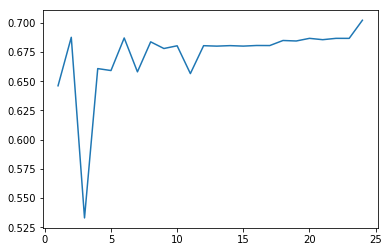

In [52]:
training_accuracy=[0 for i in range (1,25)]
testing_accuracy=[0 for i in range (1,25)]
for k in range(1,25):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    training_accuracy[k-1]=jaccard_similarity_score(y_train, neigh.predict(X_train))
    testing_accuracy[k-1]=jaccard_similarity_score(y_test, yhat)
    #training_accuracy[k-1]=metrics.accuracy_score(y_train, neigh.predict(X_train))
    #testing_accuracy[k-1]=metrics.accuracy_score(y_test, yhat)
    #print("k=",k, ",", training_accuracy[k-1],",",testing_accuracy[k-1])
    
k=[i for i in range(1,25)]        
print("The best k value is",k[np.argmax(testing_accuracy)], "at training accuracy of", training_accuracy[np.argmax(testing_accuracy)], " and testing accuracy of", testing_accuracy[np.argmax(testing_accuracy)])   
plt.plot(k,testing_accuracy)

In [14]:
#Now let's run the model at the optimal k and get the values
#kk=k[np.argmax(testing_accuracy)]
kk=24
neigh = KNeighborsClassifier(n_neighbors = kk).fit(X_train,y_train)
alg=0
yhat = neigh.predict(X_test)
f1[alg]=f1_score(y_test, yhat, average='weighted')
jaccard[alg]=jaccard_similarity_score(y_test, yhat)

In [15]:
print(f1[alg],jaccard[alg])

0.5886005197569327 0.7022362247868223


#### Testing decision tree model ####

The best k value is 3  at testing accuracy of 0.703623163590288


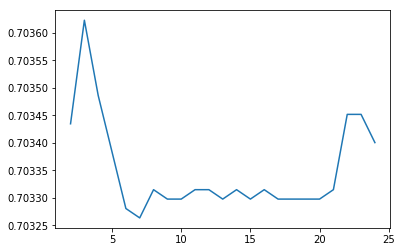

In [53]:
testing_accuracy=[0 for i in range(2,25)]
for k in range(2,25):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = k)
    Tree.fit(X_train,y_train)
    predTree = Tree.predict(X_test)
    testing_accuracy[k-5]=jaccard_similarity_score(y_test, predTree)
    #print("k=",k, testing_accuracy[k-5])

k=[i for i in range(2,25)]
print("The best k value is",k[np.argmax(testing_accuracy)], " at testing accuracy of", max(testing_accuracy))   
plt.plot(k,testing_accuracy)

In [16]:
#kk=k[np.argmax(testing_accuracy)]
kk=3
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = kk)
Tree.fit(X_train,y_train)
alg=1
yhat = Tree.predict(X_test)
f1[alg]=f1_score(y_test, yhat, average='weighted')
jaccard[alg]=jaccard_similarity_score(y_test, yhat)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
print(f1[alg],jaccard[alg])

0.5809904188654375 0.7034519365775145


#### Testing Support Vector Machine ####

In [18]:
clf = svm.SVC(kernel='linear') #change the kernel to test which one gives the best accuracy
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
print(jaccard_similarity_score(y_test, yhat))

0.7034519365775145


linear: 0.7034519365775145

poly: 0.7034519365775145

sigmoid: 0.6913975548782576

rbf: 0.7034519365775145

In [19]:
clf = svm.SVC(kernel='linear') #kernel=['rbf','linear','sigmoid','poly']
clf.fit(X_train, y_train) 
alg=2
yhat=clf.predict(X_test)
f1[alg]=f1_score(y_test, yhat, average='weighted')
jaccard[alg]=jaccard_similarity_score(y_test, yhat)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
print(f1[alg],jaccard[alg])

0.5809904188654375 0.7034519365775145


#### Testing logistic regression model ####

cc= 0.1 : 0.581460351085523 , 0.7029211328379165
cc= 0.30000000000000004 : 0.581672520348363 , 0.7029040101366392
cc= 0.7000000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 1.3000000000000003 : 0.581672520348363 , 0.7029040101366392
cc= 2.1000000000000005 : 0.581672520348363 , 0.7029040101366392
cc= 3.1000000000000005 : 0.581672520348363 , 0.7029040101366392
cc= 4.300000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 5.700000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 7.300000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 9.100000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 11.100000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 13.3 : 0.581672520348363 , 0.7029040101366392
cc= 15.700000000000001 : 0.581672520348363 , 0.7029040101366392
cc= 18.3 : 0.581672520348363 , 0.7029040101366392
cc= 21.1 : 0.581672520348363 , 0.7029040101366392
cc= 24.1 : 0.581672520348363 , 0.7029040101366392
cc= 27.3 : 0.581672520348363 , 0.7029040101366392


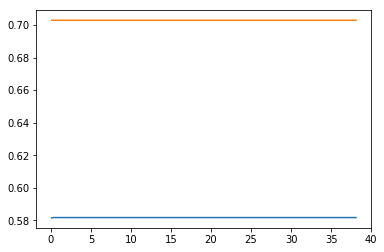

In [21]:
cc=0.1

C_value=[0 for i in range (20)]
f_one=[0 for i in range (20)]
jac=[0 for i in range (20)]
for i in range(20):
    cc=cc+i*0.2
    C_value[i]=cc
    LR = LogisticRegression(C=cc, solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    f_one[i]=f1_score(y_test, yhat, average='weighted')
    jac[i]=jaccard_similarity_score(y_test, yhat)
    print("cc=",cc,":",f_one[i],",",jac[i])
    
plt.plot(C_value,f_one,C_value,jac)


In [22]:
cc=0.1 #c value clearly doesn't matter here
LR = LogisticRegression(C=cc, solver='liblinear').fit(X_train,y_train)
alg=3
yhat = LR.predict(X_test)
f1[alg]=f1_score(y_test, yhat, average='weighted')
jaccard[alg]=jaccard_similarity_score(y_test, yhat)

In [23]:
print(f1[alg],jaccard[alg])

0.581460351085523 0.7029211328379165


In [24]:
accuracy=list(zip(jaccard,f1))
metric_df=pd.DataFrame(data=accuracy, index=algorithm, columns=('Jaccard','F1-score'))
metric_df = metric_df.rename_axis(index='Algorithm')
metric_df

,Jaccard,F1-score
Algorithm,,
KNN,0.702236,0.588601
Decision Tree,0.703452,0.580990
SVM,0.703452,0.580990
Logistic Regression,0.702921,0.581460
